In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
folder_path = '/content/drive/MyDrive/Number_Plate/'
files = os.listdir(folder_path)
print(files)


['.DS_Store', 'dataset', 'anchors.py', 'ciou_loss.py', 'focal_loss.py', 'loss.py', 'wandb_config.py', 'dataset.py', '__pycache__', 'wandb', '.env', 'evaluation.py', 'utils.py', 'model.py', 'run.py', 'best_model_trial_0.pth', 'best_model_trial_1.pth', 'best_model_trial_2.pth', 'best_model_trial_3.pth', 'best_model_trial_4.pth', 'best_model_trial_5.pth', 'best_model_trial_6.pth', 'best_model_trial_7.pth', 'best_model_trial_8.pth', 'best_model_trial_9.pth', 'best_model_trial_11.pth', 'best_model_trial_12.pth', 'best_model_trial_13.pth', 'best_model_trial_14.pth', 'best_model_trial_15.pth']


In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"


In [4]:
import torch
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
import os
from PIL import Image
import torchvision.transforms.functional as TF


## ------------------------------------------------------------------------
## The previous dataset loader not supported yolo file format annoation
## This is new dataset loader for ximl annotation loader for FRCNN training
## -------------------------------------------------------------------------

class VOCDataset(Dataset):
    def __init__(self, image_dir, annot_dir, transforms=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.transforms = transforms
        self.images = list(sorted(os.listdir(image_dir)))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        annot_path = os.path.join(self.annot_dir, os.path.splitext(self.images[idx])[0] + '.xml')

        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming one class: 'licence plate'

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target


from torch.utils.data import DataLoader

def collate_fn(batch):
    images, targets = tuple(zip(*batch))
    images = [TF.to_tensor(img) for img in images]
    targets = [{k: v for k, v in t.items()} for t in targets]
    return images, targets

dataset = VOCDataset('/content/drive/MyDrive/INM_705_Practice_final/Datasets/images', '/content/drive/MyDrive/INM_705_Practice_final/Datasets/annotations')
data_loader = DataLoader(dataset, batch_size=1, shuffle=True,num_workers=2, collate_fn=collate_fn)


In [ ]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet50
#from attention import ChannelAttention, SpatialAttention

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AttentionResNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        self.stage1 = nn.Sequential(base_model.conv1, base_model.bn1, base_model.relu, base_model.maxpool, base_model.layer1)
        self.stage2 = base_model.layer2
        self.stage3 = base_model.layer3
        self.stage4 = base_model.layer4

        self.ca = ChannelAttention(2048)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

def build_frcnn_with_attention(num_classes):
    backbone = AttentionResNetBackbone()
    backbone.out_channels = 2048
    anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )
    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator
    )
    return model.to(DEVICE)

def print_model_size(model):
    total_pars = sum(p.numel() for p in model.parameters())
    print(f"Total number of parameters: {total_pars}")

def collate_fn(batch):
    from torchvision.transforms import ToTensor
    images, targets = tuple(zip(*batch))
    images = [ToTensor()(img) for img in images]
    return images, targets


In [ ]:

import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb
from torchmetrics.detection.mean_ap import MeanAveragePrecision
#from model import build_frcnn_with_attention, collate_fn, print_model_size
#from dataset import VOCDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2
EPOCHS = 30
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
TRAIN_IMG_DIR = "/content/drive/MyDrive/INM_705_Practice_final/Datasets/images"
TRAIN_ANNOT_DIR = "/content/drive/MyDrive/INM_705_Practice_final/Datasets/annotations"
CHECKPOINT_PATH = "attention_frcnn_best.pth"

def evaluate(model, dataloader, epoch):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")
    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(DEVICE) for img in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            outputs = model(images)
            metric.update(outputs, targets)
    results = metric.compute()
    wandb.log({"val_mAP": results["map"], "val_mAP50": results["map_50"], "val_recall": results["mar_100"], "epoch": epoch})
    print(f"Epoch {epoch} - mAP: {results['map']:.4f}, Recall: {results['mar_100']:.4f}")

def main():
    wandb.init(project="FRCNN-x-Attention", name="FRCNN-x-Attention", config={"batch_size": BATCH_SIZE, "epochs": EPOCHS, "lr": LEARNING_RATE})

    train_dataset = VOCDataset(TRAIN_IMG_DIR, TRAIN_ANNOT_DIR)
    val_dataset = VOCDataset(TRAIN_IMG_DIR, TRAIN_ANNOT_DIR)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

    model = build_frcnn_with_attention(num_classes=NUM_CLASSES)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_map = 0
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, targets in train_loader:
            images = list(img.to(DEVICE) for img in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            total_loss += losses.item()

        avg_loss = total_loss / len(train_loader)
        wandb.log({"train_loss": avg_loss, "epoch": epoch})
        print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f}")

        evaluate(model, val_loader, epoch)

        current_map = wandb.run.summary.get("val_mAP", 0.0)
        if current_map > best_map:
            best_map = current_map
            torch.save(model.state_dict(), CHECKPOINT_PATH)
            artifact = wandb.Artifact("FRCNN-x-Attention", type="model")
            artifact.add_file(CHECKPOINT_PATH)
            wandb.log_artifact(artifact)

if __name__ == '__main__':
    main()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: abhi1199 (abhi1199-city-university-of-london) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 0 | Train Loss: 0.2117
Epoch 0 - mAP: 0.2113, Recall: 0.3726
Epoch 1 | Train Loss: 0.0815
Epoch 1 - mAP: 0.3544, Recall: 0.4970
Epoch 2 | Train Loss: 0.0703
Epoch 2 - mAP: 0.4690, Recall: 0.5675
Epoch 3 | Train Loss: 0.0600
Epoch 3 - mAP: 0.4859, Recall: 0.5707
Epoch 4 | Train Loss: 0.0554
Epoch 4 - mAP: 0.5774, Recall: 0.6450
Epoch 5 | Train Loss: 0.0536
Epoch 5 - mAP: 0.5793, Recall: 0.6507
Epoch 6 | Train Loss: 0.0508
Epoch 6 - mAP: 0.5738, Recall: 0.6459
Epoch 7 | Train Loss: 0.0496


In [ ]:
dadc5760c5180b0aa661c9e66b78c7e8af724486


In [ ]:
import torch
import gc

# Clear GPU cache
torch.cuda.empty_cache()

# Collect garbage
gc.collect()


In [ ]:

torch.cuda.empty_cache()


Detected License Plates:
→ Plate 1: LC25 QUO


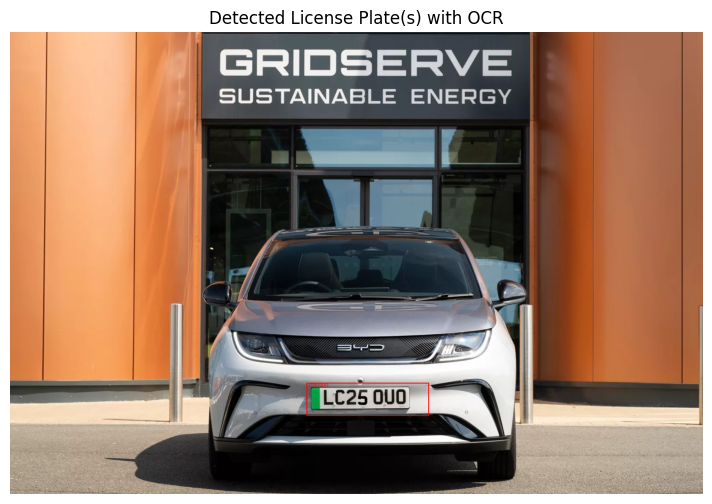

In [ ]:
import torch
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import torchvision.transforms.functional as F
import torchvision
import pytesseract
import matplotlib.pyplot as plt
#from model import build_frcnn_with_attention


MODEL_PATH = "attention_frcnn_best.pth"
TEST_IMAGE_PATH = "/content/car1.jpg"  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2
CONF_THRESHOLD = 0.5


def load_model(model_path, num_classes=NUM_CLASSES):
    model = build_frcnn_with_attention(num_classes)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()
    return model


def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    tensor = F.to_tensor(image).unsqueeze(0).to(DEVICE)
    return image, tensor


def extract_text_from_boxes(image_pil, boxes, scores, threshold=CONF_THRESHOLD):
    draw = ImageDraw.Draw(image_pil)
    font = ImageFont.load_default()
    texts = []

    for i, (box, score) in enumerate(zip(boxes, scores)):
        if score >= threshold:
            x1, y1, x2, y2 = map(int, box.tolist())

            
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

            
            crop = image_pil.crop((x1, y1, x2, y2))
            crop = ImageEnhance.Contrast(crop).enhance(2.0)

            text = pytesseract.image_to_string(
                crop,
                config='--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
            ).strip()

            if text:
                texts.append(text)
                draw.text((x1, y1), text, fill="red", font=font)

    return image_pil, texts


def run_inference(image_path, model):
    original_img, tensor_img = preprocess_image(image_path)
    with torch.no_grad():
        predictions = model(tensor_img)[0]

    boxes = predictions["boxes"]
    scores = predictions["scores"]

    result_img, plate_texts = extract_text_from_boxes(original_img.copy(), boxes, scores)
    return result_img, plate_texts

if __name__ == "__main__":
    model = load_model(MODEL_PATH)
    output_img, plate_texts = run_inference(TEST_IMAGE_PATH, model)

    print("Detected License Plates:")
    for idx, text in enumerate(plate_texts):
        print(f"→ Plate {idx + 1}: {text}")

    plt.figure(figsize=(10, 6))
    plt.imshow(output_img)
    plt.axis("off")
    plt.title("Detected License Plate(s) with OCR")
    plt.show()


In [2]:
!sudo apt install tesseract-ocr -y
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,186 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc